#Sleep Stage Classification
This project aims to develop various neural network architectures to address the problem of sleep stage classification using EEG signals as input. The performance of these architectures is compared based on multiple criteria to identify the model that achieves the best results.

To run the following cells, you should first download the dataset and then upload the two files, `Sleep_TRAIN.ts` and `Sleep_TEST.ts`, here on Google Colab. Otherwise, you can upload the files on Google Drive (Inside a folder called `project_applications_ia`) and access them by connecting Colab to Drive.

## Libraries

In [1]:
import pandas                as pd
import matplotlib.pyplot     as plt
from   matplotlib.ticker     import MaxNLocator
import numpy                 as np
from   google.colab          import drive
import os
from   tqdm                  import tqdm
from   sklearn.preprocessing import StandardScaler
from sklearn.metrics         import confusion_matrix
import torch
import torch.nn              as nn
from   torch.utils.data      import Dataset, DataLoader
import time
from   sklearn.metrics       import f1_score
from   sklearn.metrics       import classification_report
import seaborn               as sns

## Dataset

The data used in this project is the **Sleep dataset**, sourced from the [TimeSeriesClassification.com](https://www.timeseriesclassification.com/description.php?Dataset=Sleep) repository (hosted by UEA/UCR). This dataset is a pre-processed version of the renowned **PhysioNet Sleep-EDF database**.

It consists of single-channel **EEG signals** (Electroencephalogram) sampled at **100Hz**. Each sample represents a short window of brain activity characterized by:

* **Time Steps**: 178 points.
* **Target**: One of 5 sleep stages based on the AASM standard:
    * `0`: **Wake**
    * `1`: **N1** (Non rapid eye movement type 1)
    * `2`: **N2** (Non rapid eye movement type 2)
    * `3`: **N3** (Non rapid eye movement type 3)
    * `4`: **REM** (Rapid Eye Movement)

The EEG signals are recorded at a sampling frequency of **100 Hz**, meaning 100 data points are collected every second. Since each sample in this dataset consists of **178 time steps**, each observation represents a temporal window of approximately **1.78 seconds**.

---

The original training set is significantly large (over 470,000 samples) and exhibits a **high class imbalance**, which faithfully reflects the natural distribution of human sleep architecture:

* **N2 (Light Sleep)**: The dominant class, comprising nearly **50%** of the total recordings.
* **N1 (Transition)**: The rarest class, representing only a **small fraction** (approx. 5%) of the data.





In [2]:
# Connect to google drive.
drive.mount('/content/drive')

# Path to the dataset within my Google Drive.
path = '/content/drive/MyDrive/progetto_applicazioni_ia/'

# Read train and test data.
df_train_complete = pd.read_csv(path + 'Sleep_TRAIN.ts', skiprows = 7, sep=',|:', header=None, engine = 'python')
df_test_complete  = pd.read_csv(path + 'Sleep_TEST.ts',  skiprows = 7, sep=',|:', header=None, engine = 'python')

print(f"\nTraining set shape: {df_train_complete.shape}")
print(f"Test set shape:  {df_test_complete.shape}\n")
print("-----------------------------")
print("\nTRAINING SET: class distribution")
print(df_train_complete.iloc[:, -1].value_counts())
print("\n-----------------------------\n")
print("TESTING SET: class distribution")
print(df_test_complete.iloc[:, -1].value_counts())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Training set shape: (478785, 179)
Test set shape:  (90315, 179)

-----------------------------

TRAINING SET: class distribution
178
2    222795
4    100200
3     68550
0     55095
1     32145
Name: count, dtype: int64

-----------------------------

TESTING SET: class distribution
178
2    44190
3    16995
4    15555
1     9915
0     3660
Name: count, dtype: int64


### Balancing Strategy

To mitigate the risk of the model developing a bias toward the majority class (N2), a simple balancing strategy is implemented. Instead of utilizing the entire imbalanced dataset, we performed a balanced under-sampling by extracting exactly **30,000 random samples for each of the five classes**. This resulted in a refined training set of **150,000 samples**, ensuring that the neural network receives equal exposure to all sleep stages during the training.

Furthermore, this approach significantly optimizes memory usage in the Google Colab environment, since a dataset as large as this would require a lot of RAM.


In [3]:
# We take 20,000 samples per class. This way, we'll have a balanced training set.
samples_per_class = 30000
balanced_list     = []

for label in range(5):
    # We select only the samples with that specific label.
    subset = df_train_complete[df_train_complete.iloc[:, -1] == label]

    # We randomly draw the specified number of samples for that class.
    subset = subset.sample(n = samples_per_class, random_state = 42)
    balanced_list.append(subset)

# Merging everything into a single new dataframe
df_train = pd.concat(balanced_list)

# Cleaning the RAM.
del balanced_list
del df_train_complete

# Shuffling data
df_train = df_train.sample(frac = 1, random_state = 42).reset_index(drop = True)

print(f"New balanced training set shape: {df_train.shape}")
print("\nNew distribution (Train):")
print(df_train.iloc[:, -1].value_counts())

New balanced training set shape: (150000, 179)

New distribution (Train):
178
1    30000
0    30000
4    30000
3    30000
2    30000
Name: count, dtype: int64


In [4]:
# Selecting training data and labels and converting it to numpy arrays.
X_train = df_train.iloc[:, :178].values.astype('float32')
y_train = df_train.iloc[:, 178].values.astype('int32')

# Selecting test data and labels and converting it to numpy arrays.
X_test = df_test_complete.iloc[:, :178].values.astype('float32')
y_test = df_test_complete.iloc[:, 178].values.astype('int32')

# Cleaning the RAM.
del df_train
del df_test_complete

# Printing some info.
print(f"X_train is of type {type(X_train)} and has shape {X_train.shape}")
print(f"X_test is of type {type(X_test)} and has shape {X_test.shape}")
print(f"\ny_train is of type {type(y_train)} and has shape  {y_train.shape}")
print(f"y_test is of type {type(y_test)} and has shape {y_test.shape}")

X_train is of type <class 'numpy.ndarray'> and has shape (150000, 178)
X_test is of type <class 'numpy.ndarray'> and has shape (90315, 178)

y_train is of type <class 'numpy.ndarray'> and has shape  (150000,)
y_test is of type <class 'numpy.ndarray'> and has shape (90315,)


 ### Preprocessing
To facilitate model convergence and ensure that features are treated equally, we applied **Standardization (Z-score normalization)** using the `StandardScaler` method. This process transforms the signals to have a mean of 0 and a standard deviation of 1. The scaling parameters were computed on the training set and subsequently applied to the test set to prevent data leakage.

In [5]:
# Dictionary that maps each label in the corresponding string to the sleep stage
sleep_labels_map = {
    0: "Wake",
    1: "N1",
    2: "N2",
    3: "N3",
    4: "REM"
}

# The data is standardized.
scaler = StandardScaler()
# The mean and standard deviation are calculated from the training set.
scaler.fit(X_train)

# Both datasets are standardized.
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

### Data Visualization After Preprocessing and balancing

The following visualizations illustrate the dataset after balancing and preprocessing:

1. **EEG Signal Samples**: a selection of 6 randomly sampled EEG recordings is displayed to inspect the signal morphology across different stages.
2. **Class Distribution**: a bar chart compares the composition of the training and test sets.

While the training set is now perfectly balanced with an equal number of samples per class, the test set retains its original distribution. This highlights the inherent imbalance of the data, where the N2 stage is significantly more abundant than the other sleep phases.

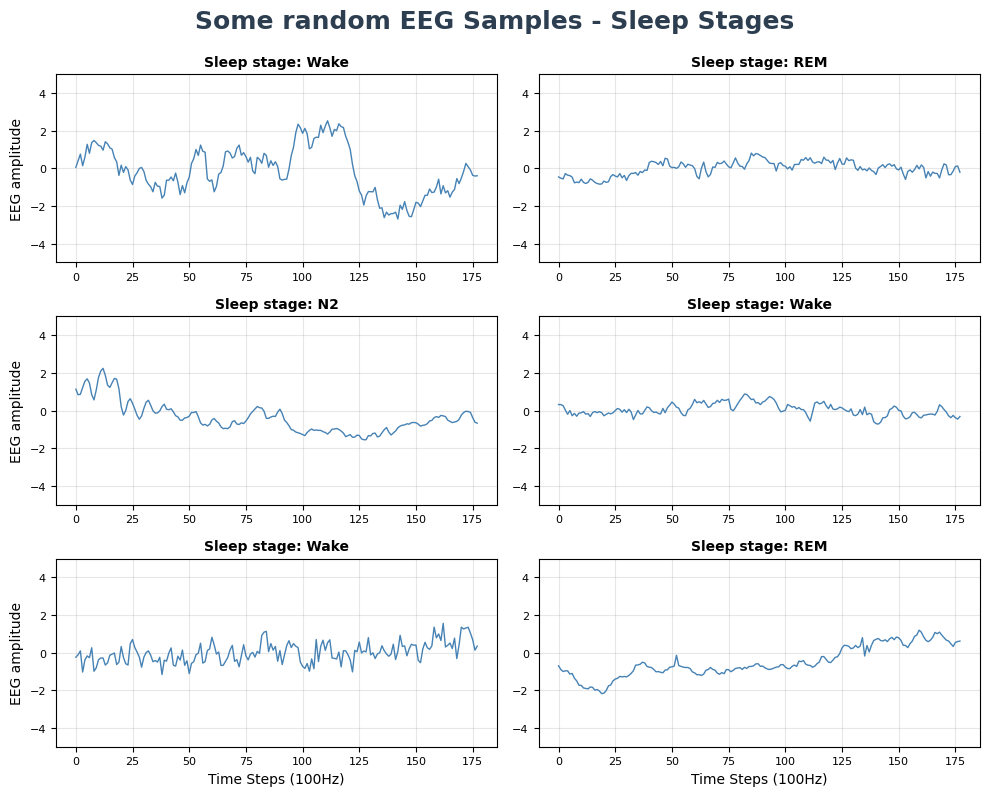

In [6]:
# Extracting 6 random data for visualization.
random_samples = np.random.choice(len(X_train), size = 6, replace = False)

plt.figure(figsize=(10, 8))
plt.suptitle("Some random EEG Samples - Sleep Stages", color = '#2c3e50', fontsize = 18, fontweight = 'extra bold', fontfamily = 'sans-serif', y = 0.99)

for i, idx in enumerate(random_samples):
    plt.subplot(3, 2, i + 1)

    # Numeric label retrieval and dictionary translation.
    sleep_stage = sleep_labels_map[y_train[idx]]

    # Plotting the signal.
    plt.plot(X_train[idx], color = 'steelblue', linewidth = 1)

    # Setting a title.
    plt.title(f"Sleep stage: {sleep_stage}", fontweight='bold', fontsize = 10)

    plt.grid(True, alpha = 0.3)
    # Assicurati che questo ylim sia adatto ai tuoi dati, altrimenti commentalo
    plt.ylim(-5, 5)

    if i >= 4: plt.xlabel("Time Steps (100Hz)")
    if i % 2 == 0: plt.ylabel("EEG amplitude")

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

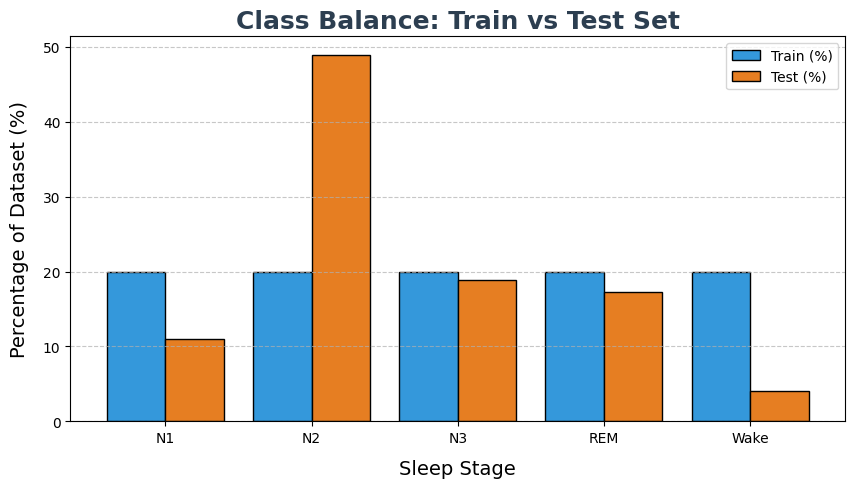

In [7]:
# Map numeric labels to names for both sets.
train_labels = pd.Series(y_train).map(sleep_labels_map)
test_labels = pd.Series(y_test).map(sleep_labels_map)

# Combine percentages into one DataFrame for easy comparison.
df_dist = pd.DataFrame({
    'Train (%)': train_labels.value_counts(normalize = True) * 100,
    'Test (%)': test_labels.value_counts(normalize = True) * 100
}).sort_index()

# Plot side-by-side bars, showing class balance.
df_dist.plot(kind = 'bar', figsize = (10, 5), color = ['#3498db', '#e67e22'], edgecolor = 'black', width=0.8)

plt.title("Class Balance: Train vs Test Set", color = '#2c3e50', fontsize = 18, fontweight = 'extra bold', fontfamily = 'sans-serif')
plt.ylabel("Percentage of Dataset (%)", fontsize = 14, labelpad = 10)
plt.xlabel("Sleep Stage", fontsize = 14, labelpad = 10)
plt.xticks(rotation = 0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(frameon = True)
plt.show()

## Utilities

This section section contains the core infrastructure of the deep learning pipeline, including the `SleepDataset` class for dataset management and the functions for training and testing.

In [8]:
# Custom dataset class.
class SleepDataset(Dataset):
    def __init__(self, X, y):
        # The data (EEG signals) and labels are transformed into PyTorch tensors.
        self.X = torch.tensor(X, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Adding a new dimension at index 1.
        return self.X[idx].unsqueeze(1), self.y[idx]

In [9]:
def train_epoch(epoch, model, loader, criterion, optimizer, device = "cpu"):
    """
    This function manages the training loop for a single epoch, iterating through batches
    to perform forward and backward passes for weight updates.
    It calculates and returns the average loss and accuracy to monitor the model's learning progress.
    """
    # Setting train mode.
    model.train()

    # Some diagnostic variables are updated during training.
    running_loss = 0.0
    correct      = 0
    total        = 0

    loop = tqdm(loader, desc = f'Epoch {epoch:03d}', leave = False)
    # Looping through each batch of data.
    for data in loop:
        x = data[0].to(device)
        y = data[1].to(device)

        # Reset gradients.
        optimizer.zero_grad()
        # Forward pass.
        out  = model(x)
        # Computing the loss.
        loss = criterion(out, y)
        # Backpropagation and weights update.
        loss.backward()
        optimizer.step()

        # Calculating some statistics during training.
        running_loss += loss.item()
        # Computing accuracy.
        _, predicted = torch.max(out.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

        # Update the bar with the current loss.
        loop.set_postfix(loss=loss.item())
    # Returning the average loss and accuracy.
    return running_loss, correct / total


def test_model(model, loader, criterion, device = "cpu"):
    """
    This function evaluates the model's performance.
    It computes the cumulative loss, accuracy, and F1 score.
    """
    # Evaluating model.
    model.eval()

    running_loss = 0.0
    correct      = 0
    total        = 0

    # Lists containing the actual predictions and the actual labels.
    # They are used to calculate metrics such as F1 scores.
    y_true = []
    y_pred = []

    loop = tqdm(loader, desc = "Validating")

    with torch.no_grad():
        for data in loop:
            x = data[0].to(device)
            y = data[1].to(device)
            # Forward pass.
            out = model(x)
            # Computing the loss.
            loss = criterion(out, y)
            # Updating the total loss.
            running_loss += loss.item()
            # Collecting the predictions.
            _, predicted = torch.max(out.data, 1)
            total   += y.size(0)
            correct += (predicted == y).sum().item()

            # Converting the tensors into lists.
            y_true += y.tolist()
            y_pred += predicted.tolist()

    return running_loss, correct / total, f1_score(y_true, y_pred, average='macro'), y_true, y_pred


def train(model, train_loader, criterion, optimizer, device="cpu", num_epochs = 5):
    """
    This function coordinates the overall training process by iterating through the specified number of epochs.
    It tracks the model's performance over time, storing and returning the history of loss and accuracy for each epoch.
    """
    # Lists to save the progess of loss and accuracy during the epochs.
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        loss, acc = train_epoch(epoch + 1, model, train_loader, criterion, optimizer, device)

        train_losses.append(loss)
        train_accuracies.append(acc)

        print(f"Epoch {epoch + 1} / {num_epochs} | Train Loss: {loss:.4f} Acc: {acc * 100:.2f}%")

    return train_losses, train_accuracies

In [10]:
def plot_learning_curves(losses, accuracies):
    """
    This function generates a side-by-side visualization of the training history,
    plotting the progression of both loss and accuracy over the epochs.
    """
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(10, 8))

    # LOSS CHART.
    plt.subplot(2, 1, 1)
    plt.plot(epochs, losses, 'r-o', label='Training Loss', linewidth=2, markersize=5)
    plt.title('Training Loss', fontsize=14, fontweight='bold', pad=12)
    plt.xlabel('Epochs', fontsize=12, fontweight='medium')
    plt.ylabel('Loss', fontsize=12, fontweight='medium')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # ACCURACY ON TRAINING SET CHART.
    plt.subplot(2, 1, 2)
    acc_percentage = [a * 100 for a in accuracies]
    plt.plot(epochs, acc_percentage, 'b-s', label='Training Accuracy', linewidth=2, markersize=5)
    plt.title('Training Accuracy', fontsize=14, fontweight='bold', pad=12)
    plt.xlabel('Epochs', fontsize=12, fontweight='medium')
    plt.ylabel('Accuracy (%)', fontsize=12, fontweight='medium')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

In [11]:
# Device selection (GPU if available).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes   = 5
learning_rate = 0.0001
batch_size    = 64

# Creating Datasets.
train_dataset = SleepDataset(X_train, y_train)
test_dataset  = SleepDataset(X_test, y_test)

# Creating Data Loaders.
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader  = DataLoader(test_dataset, batch_size = batch_size)

## Models
Various neural network architectures are defined and their performances are evaluated through a comparative analysis based on the most common classification metrics.

### Model 1: Multi-Layer Perceptron
We defined a simple MLP with a 512-neuron hidden layer as a baseline architecture. Due to the loss of temporal and spatial information caused by input flattening, this model proved unsuitable for the task. Training comparisons showed that increasing the number of epochs did not improve generalization but instead led to overfitting. The model performed poorly overall, with accuracy remaining below 50%.

In [12]:
# Simple MLP with a hidden layer.
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Dimension: [Batch size, eeg_data]
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [13]:
# Hyperparameters
input_size    = 178
hidden_size   = 512
num_classes   = 5
learning_rate = 0.0001

# We compare the performance of an MLP with a different number of epochs.
# epoch_stages = [5, 10, 20, 30]
##epoch_stages = [5, 10, 20, 30]
epoch_stages = [10]
results = {}

for target_epochs in epoch_stages:
    print(f"\n--- {target_epochs} epochs ---")

    # Model initialization, loss function and optimizer.
    model = MLP(input_size, hidden_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    # Training.
    train_history = train(model, train_loader, criterion, optimizer, device, num_epochs = target_epochs)

    # Evaluating the model.
    test_loss_1, test_acc_1, test_f1_1, y_true_1, y_pred_1 = test_model(model, test_loader, criterion, device)

    # We save the metrics.
    results[target_epochs] = {'Acc': test_acc_1, 'F1': test_f1_1}

    print(f"Final results ({target_epochs} epochs): Acc {test_acc_1 * 100:.2f}% | F1 {test_f1_1:.2f}")


--- 10 epochs ---


Epoch 1 / 10 | Train Loss: 3285.1227 Acc: 38.81%


Epoch 2 / 10 | Train Loss: 3029.0594 Acc: 46.06%


Epoch 3 / 10 | Train Loss: 2917.9767 Acc: 49.05%


Epoch 4 / 10 | Train Loss: 2835.7183 Acc: 51.12%


Epoch 5 / 10 | Train Loss: 2767.6005 Acc: 52.72%


Epoch 6 / 10 | Train Loss: 2707.4547 Acc: 53.96%


Epoch 7 / 10 | Train Loss: 2654.0287 Acc: 55.05%


Epoch 8 / 10 | Train Loss: 2608.4418 Acc: 55.91%


Epoch 9 / 10 | Train Loss: 2571.2745 Acc: 56.46%


Epoch 10 / 10 | Train Loss: 2539.4505 Acc: 56.94%


Validating: 100%|██████████| 1412/1412 [00:01<00:00, 888.34it/s]


Final results (10 epochs): Acc 48.99% | F1 0.46


As shown in the graphs, the most effective training happens early on: the loss falls quickly, and accuracy improves significantly. Although the model continues to learn in later epochs, the improvements become less marked. It is also clear that better training results do not always translate to generalization. On the contrary, increasing the epoch count causes overfitting, which hurts performance on new data.

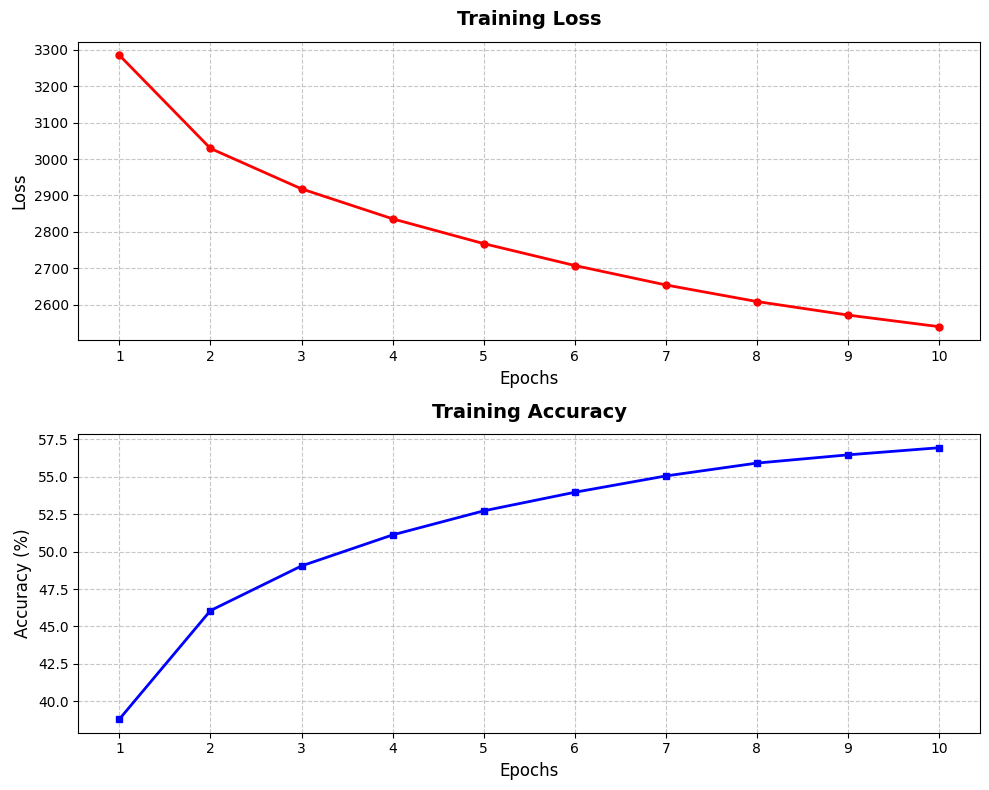


--- FINAL SUMMARY ---
Epochs: 10 | Accuracy: 48.99% | F1-Score: 0.46


In [14]:
# Plotting the charts for the training on 30 epochs.
train_losses_1, train_accuracies_1 = train_history
plot_learning_curves(train_losses_1, train_accuracies_1)

# Final summary.
print("\n--- FINAL SUMMARY ---")
for ep, metrics in results.items():
   print(f"Epochs: {ep:02d} | Accuracy: {metrics['Acc']*100:.2f}% | F1-Score: {metrics['F1']:.2f}")

### Model 2: 1D-Convolutional Backbone  +  Classification Head

A 1-Dimensional Convolutional Neural Network (CNN) that consists of two parts is implemented:
1. **Feature Extractor**: this part comprises two sequential convolutional blocks. The first block utilizes 32 filters with a kernel size of 7 to capture broader temporal patterns, while the second block increases the depth to 64 filters with a kernel size of 5 for finer feature detection. Each convolution is followed by ReLU activation and Max Pooling (stride 2), which progressively downsamples the temporal dimension from 178 to 44 time steps. Of course, since we are dealing with time series, kernels are one-dimensional.
2. **Classification Head**: the extracted high-dimensional features (64 channels $\times$ 44 time steps) are flattened into a vector of 2,816 elements. This vector is passed through a fully connected block containing a hidden layer with 256 neurons which acts as a final classifier.

In [15]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # First convolutional layer.
        # 32 filters of size 7 are used, and the pooling is performed.
        # Input: [Batch, 1, 178] -> Output: [Batch, 32, 89]
        self.convLayer1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # Second convolutional layer.
        # 64 filters of size 5 are used, and the pooling is perdormed.
        # Input: [Batch, 32, 89] -> Output: [Batch, 64, 44]
        self.convLayer2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # Classification head.
        # A dense layer with 256 neurons is added.
        self.classificationLayer = nn.Sequential(
            nn.Linear(64 * 44, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is a batch of data.
        # The input is rephrased in a different format.
        # Permute: [Batch, 178, 1] -> [Batch, 1, 178]
        if x.shape[2] == 1:
             x = x.permute(0, 2, 1)

        # Features are extracted through the convolutional layers.
        out = self.convLayer1(x)
        out = self.convLayer2(out)

        # Flattening.
        out = out.reshape(out.size(0), -1)

        # Classification.
        out = self.classificationLayer(out)
        return out

In [32]:
# Hyperparameters.
learning_rate = 0.0001
num_epochs    = 10
num_classes   = 5

# Initializing the model.
model = CNN(num_classes = num_classes).to(device)

# Defining the loss funzion anche the optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Training.
print(f"--- Training CNN ({num_epochs} epochs) ---")
train_losses_2, train_accuracies_2 = train(model, train_loader, criterion, optimizer, device, num_epochs = num_epochs)

# Testing.
print("\n--- Testing the model ---")
test_loss_2, test_acc_2, test_f1_2, y_true_2, y_pred_2 = test_model(model, test_loader, criterion, device)

# Printing the final results.
print(f"\nFinal Results:")
print(f"Accuracy: {test_acc_2 * 100:.2f}%")
print(f"Macro F1-Score: {test_f1_2:.2f}")

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_true_2, y_pred_2, target_names = ['WAKE', 'N1', 'N2', 'N3', 'REM'], zero_division = 0))

--- Training CNN (10 epochs) ---


Epoch 1 / 10 | Train Loss: 2601.5047 Acc: 53.79%


Epoch 2 / 10 | Train Loss: 2326.9167 Acc: 58.70%


Epoch 3 / 10 | Train Loss: 2251.6148 Acc: 60.14%


Epoch 4 / 10 | Train Loss: 2205.3046 Acc: 61.05%


Epoch 5 / 10 | Train Loss: 2175.0782 Acc: 61.67%


Epoch 6 / 10 | Train Loss: 2148.4063 Acc: 62.08%


Epoch 7 / 10 | Train Loss: 2124.3911 Acc: 62.64%


Epoch 8 / 10 | Train Loss: 2103.6860 Acc: 63.04%


Epoch 9 / 10 | Train Loss: 2084.0970 Acc: 63.44%


Epoch 10 / 10 | Train Loss: 2067.5551 Acc: 63.82%

--- Testing the model ---


Validating: 100%|██████████| 1412/1412 [00:01<00:00, 715.87it/s]



Final Results:
Accuracy: 57.20%
Macro F1-Score: 0.53

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        WAKE       0.38      0.55      0.45      3660
          N1       0.29      0.47      0.36      9915
          N2       0.85      0.51      0.64     44190
          N3       0.66      0.83      0.74     16995
         REM       0.40      0.55      0.46     15555

    accuracy                           0.57     90315
   macro avg       0.52      0.58      0.53     90315
weighted avg       0.66      0.57      0.59     90315



### Model 3: LSTM

The third architecture employed is the LSTM. Unlike the MLP (which flattens the input) or the CNN (which looks for local features), the LSTM is specifically designed to process the EEG signal as a time sequence, capturing temporal dependencies and the evolution of the signal over time.

The model consists of a LSTM with 2 layers and a hidden state dimension of 64. It processes the input sequence ($178$ time steps) sequentially. To perform the classification, the architecture adopts a "Many-to-One" strategy: only the hidden state of the last time step ($t=178$) is extracted, effectively acting as a summary vector of the entire signal. This final representation is passed to a single linear layer to directly compute the logits for the 5 target sleep stages.

In [33]:
class LSTM(nn.Module):
    # num_layers indicates how many LSTMs we stack on top of each other.
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        # LSTM. It takes inputs of shape [Batch_size, length, features].
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        # Dense level that is responsible for carrying out the final classification.
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: [Batch_size, 178, 1]
        out, _ = self.lstm(x)
        # Many to one architecture. Selects the output of the last time step, which summarizes the entire sequence.
        out = out[:, -1, :]
        # We pass the result (of size [Batch_size, hidden_size]) to the final
        # dense layer, who is responsible for the final classification.
        out = self.fc(out)

        return out

In [35]:
# Hyperparameters.
input_size    = 1
hidden_size   = 64
num_layers    = 2
learning_rate = 0.001
num_epochs    = 10
num_classes   = 5

# Instantiating the model, the loss and the optimizer.
model     = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Training.
print(f"--- Training LSTM ({num_epochs} epochs) ---")
train_losses_3, train_accuracies_3 = train(model, train_loader, criterion, optimizer, device, num_epochs = num_epochs)

# Testing.
print("\n--- Testing the model ---")
test_loss_3, test_acc_3, test_f1_3, y_true_3, y_pred_3 = test_model(model, test_loader, criterion, device)

# Printing the final results.
print(f"\nFinal Results:")
print(f"Accuracy: {test_acc_3 * 100:.2f}%")
print(f"Macro F1-Score: {test_f1_3:.2f}")

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_true_3, y_pred_3, target_names = ['WAKE', 'N1', 'N2', 'N3', 'REM'], zero_division = 0))

--- Training LSTM (10 epochs) ---


Epoch 1 / 10 | Train Loss: 3579.6015 Acc: 27.85%


Epoch 2 / 10 | Train Loss: 3375.0995 Acc: 34.04%


Epoch 3 / 10 | Train Loss: 2990.6356 Acc: 44.22%


Epoch 4 / 10 | Train Loss: 2661.0686 Acc: 51.45%


Epoch 5 / 10 | Train Loss: 2353.4086 Acc: 57.40%


Epoch 6 / 10 | Train Loss: 2221.5011 Acc: 60.39%


Epoch 7 / 10 | Train Loss: 2166.3358 Acc: 61.53%


Epoch 8 / 10 | Train Loss: 2156.0135 Acc: 61.80%


Epoch 9 / 10 | Train Loss: 2109.3958 Acc: 62.69%


Epoch 10 / 10 | Train Loss: 2089.8276 Acc: 63.00%

--- Testing the model ---


Validating: 100%|██████████| 1412/1412 [00:02<00:00, 555.78it/s]



Final Results:
Accuracy: 58.70%
Macro F1-Score: 0.55

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        WAKE       0.41      0.65      0.50      3660
          N1       0.30      0.47      0.37      9915
          N2       0.85      0.54      0.66     44190
          N3       0.70      0.79      0.74     16995
         REM       0.41      0.57      0.48     15555

    accuracy                           0.59     90315
   macro avg       0.53      0.60      0.55     90315
weighted avg       0.67      0.59      0.60     90315



### Model 4: 1D-Convolutional Feature Extractor $+$ LSTM Layer $+$ Linear Classificator

The last model is a hybrid model which aims to combine the strengths of the two previous architectures:

1.  **CNN:** extracts features from the EEG signals.
2.  **LSTM:** analyzes how these features evolve over time, capturing the sequential temporal dependencies typical of sleep stages.

Here's the data flow::

1.  **Feature Extraction (1D-CNN):**
    * The signal passes through two convolutional blocks.
    * We use padding ($P = K // 2$) to keep the temporal dimension unchanged during convolution.
    * After each convolution, we apply Max Pooling, which halves the temporal resolution but increases the depth (number of filters).
    * ReLU is also used after each convolution.

2.  **Sequence Analysis (LSTM):**
    * The CNN output is permuted to match the format required by the LSTM.
    * The number of filters from the last CNN layer becomes the input size for the LSTM.
    * The reduced temporal length (due to pooling) becomes the sequence length that the LSTM must "read".

3.  **Classification (Many-to-One):**
    * We adopt a **Many-to-One** strategy: we discard intermediate outputs and select only the final hidden state  of the LSTM.
    * This vector summarizes the entire time window and is passed to a single linear layer for final classification.


In [19]:
class HybridModel(nn.Module):
    def __init__(self,
                 num_filters_1,
                 num_filters_2,
                 kernel_size,
                 lstm_hidden_size,
                 lstm_num_layers,
                 num_classes):

        super(HybridModel, self).__init__()

        # Computing the padding. The dimension.
        # The vector dimensions remain unchanged after applying the filter.
        padding_val = kernel_size // 2

        # 1. 1-D CNN (FEATURE EXTRACTOR).
        self.cnn = nn.Sequential(
            # First convolutional layer. It takes in input the EEG signal.
            nn.Conv1d(1, num_filters_1, kernel_size = kernel_size, padding = padding_val),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),

            # Second convolutional layer.
            nn.Conv1d(num_filters_1, num_filters_2, kernel_size = kernel_size, padding = padding_val),
            nn.ReLU(),
            nn.MaxPool1d(2, 2)
        )

        # LSTM block.
        self.lstm = nn.LSTM(input_size  = num_filters_2,
                            hidden_size = lstm_hidden_size,
                            num_layers  = lstm_num_layers,
                            batch_first = True)
        # Final linear classificator. It takes the final memory from the LSTM
        # and map it to the 5 classes.
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        # x has shape [Batch_size, 178, 1].
        # Changing the shape of data for CNN.
        x = x.permute(0, 2, 1)
        # Data is passed through the cnn block.
        x = self.cnn(x)
        # Changing the shape of data for LSTM
        x = x.permute(0, 2, 1)
        # Data is passed through the LSTM block.
        out, _ = self.lstm(x)
        # Many-to-One problem. We only take the hidden state from the last
        # time instant-
        out = out[:, -1, :]
        # We pass data through the linear classificator.
        out = self.fc(out)
        return out

In [28]:
# Hyperparameters
num_classes      = 5
learning_rate    = 0.001
num_epochs       = 9
num_filters_1    = 64
num_filters_2    = 128
kernel_size      = 5
lstm_hidden_size = 64
lstm_num_layers  = 2

# Instantiating the model, the loss and the optimizer.
model = HybridModel(num_filters_1, num_filters_2, kernel_size, lstm_hidden_size, lstm_num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Training.
print(f"--- Training Hybrid model (CNN + LSTM) ({num_epochs} epochs) ---")
train_losses_4, train_accuracies_4 = train(model, train_loader, criterion, optimizer, device, num_epochs=num_epochs)

# Testing.
print("\n--- Testing the model ---")
test_loss_4, test_acc_4, test_f1_4, y_true_4, y_pred_4 = test_model(model, test_loader, criterion, device)

# Printing the final results.
print(f"\nFinal Results:")
print(f"Accuracy: {test_acc_4 * 100:.2f}%")
print(f"Macro F1-Score: {test_f1_4:.2f}")

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_true_4, y_pred_4, target_names=['WAKE', 'N1', 'N2', 'N3', 'REM'], zero_division = 0))

--- Training Hybrid model (CNN + LSTM) (9 epochs) ---


Epoch 1 / 9 | Train Loss: 2529.5855 Acc: 54.15%


Epoch 2 / 9 | Train Loss: 2227.3517 Acc: 60.57%


Epoch 3 / 9 | Train Loss: 2134.7488 Acc: 62.36%


Epoch 4 / 9 | Train Loss: 2081.2976 Acc: 63.20%


Epoch 5 / 9 | Train Loss: 2043.0489 Acc: 63.87%


Epoch 6 / 9 | Train Loss: 2016.8796 Acc: 64.27%


Epoch 7 / 9 | Train Loss: 1992.8333 Acc: 64.64%


Epoch 8 / 9 | Train Loss: 1974.6226 Acc: 64.88%


Epoch 9 / 9 | Train Loss: 1952.8336 Acc: 65.29%

--- Testing the model ---


Validating: 100%|██████████| 1412/1412 [00:02<00:00, 478.62it/s]



Final Results:
Accuracy: 61.68%
Macro F1-Score: 0.56

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        WAKE       0.41      0.62      0.49      3660
          N1       0.34      0.41      0.37      9915
          N2       0.84      0.58      0.68     44190
          N3       0.68      0.83      0.75     16995
         REM       0.46      0.63      0.53     15555

    accuracy                           0.62     90315
   macro avg       0.54      0.61      0.56     90315
weighted avg       0.67      0.62      0.63     90315



### Results

In this final section, we analyze the performance of the four architectures (MLP, CNN, LSTM, and Hybrid) based on the experimental results.


#### **1. Training Dynamics (Loss & Accuracy)**
The learning curves demonstrate significant differences in convergence speed:
* **Hybrid:** Shows the most stable and fastest convergence. It achieves the lowest loss and highest training accuracy.
* **LSTM:** interestingly, it starts with the lowest accuracy (even below MLP) but shows a steep learning curve, eventually overtaking the MLP and matching the CNN.
* **MLP:** exhibits the slowest learning rate and highest final loss, confirming its inability to capture complex temporal patterns in EEG data.

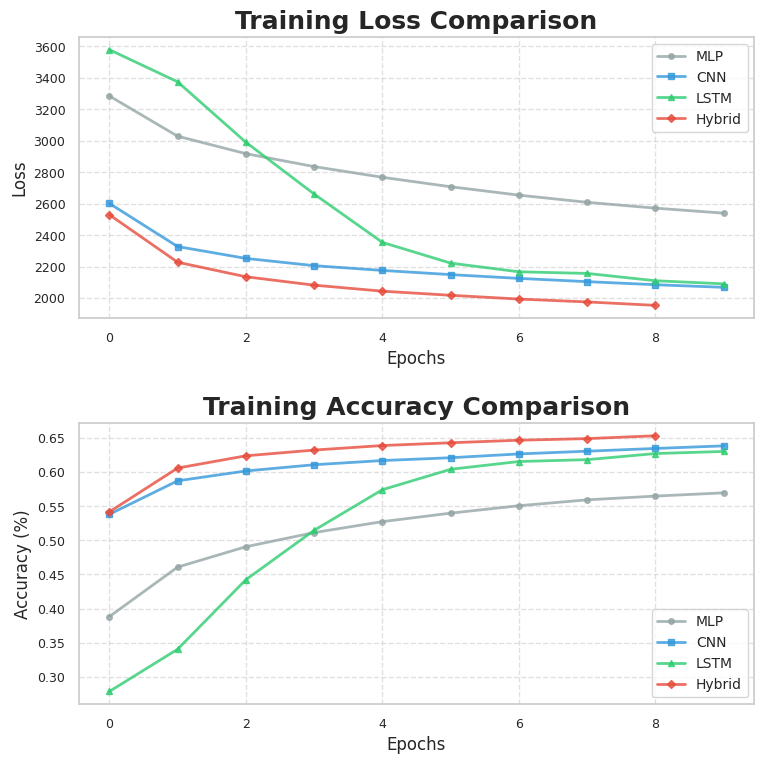

In [36]:
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 10
})

# Data.
model_names = ['MLP', 'CNN', 'LSTM', 'Hybrid']
colors      = ['#95a5a6', '#3498db', '#2ecc71', '#e74c3c']
markers     = ['o', 's', '^', 'D']

all_losses = [train_losses_1, train_losses_2, train_losses_3, train_losses_4]
all_accs   = [train_accuracies_1, train_accuracies_2, train_accuracies_3, train_accuracies_4]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# Chart for training loss comparison.
for i, name in enumerate(model_names):
    ax1.plot(all_losses[i], label = name, color = colors[i],
             linewidth=2, marker=markers[i], markersize=4, alpha = 0.8)

ax1.set_title('Training Loss Comparison', fontweight = 'bold', fontsize = 18)
ax1.set_ylabel('Loss', fontsize = 12)
ax1.set_xlabel('Epochs', fontsize = 12)
ax1.legend(loc = 'upper right')
ax1.grid(True, linestyle='--', alpha=0.6)

# # Chart for training accuracy comparison.
for i, name in enumerate(model_names):
    ax2.plot(all_accs[i], label = name, color = colors[i],
             linewidth = 2, marker = markers[i], markersize = 4, alpha = 0.8)

ax2.set_title('Training Accuracy Comparison', fontweight = 'bold', fontsize = 18)
ax2.set_ylabel('Accuracy (%)', fontsize = 12)
ax2.set_xlabel('Epochs', fontsize = 12)
ax2.legend(loc = 'lower right')
ax2.grid(True, linestyle = '--', alpha = 0.6)

plt.tight_layout(pad=2.0)
plt.show()

#### **2. Model Comparison (Test Set)**
The bar chart highlights a clear hierarchy in performance:
* **MLP:** lowest performance (Accuracy: 49.7%, F1: 46.2%).
* **CNN & LSTM:** both provide a solid improvement over MLP, with LSTM slightly edging out the CNN in accuracy (58.2% vs 56.0%).
* **Hybrid CRNN:** the winner, achieving the highest Accuracy (61.4%) and F1-Score (56.2%).

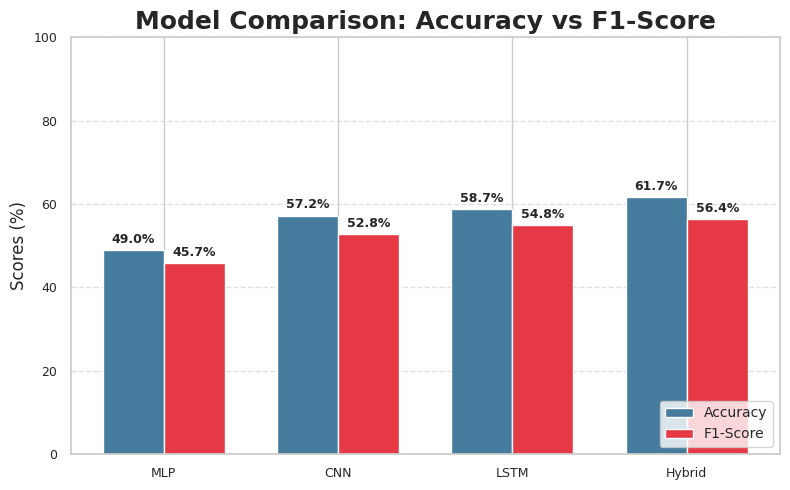

In [37]:
# Comparison of metrics on the 4 models.
model_names = ['MLP', 'CNN', 'LSTM', 'Hybrid']
accuracies  = [test_acc_1, test_acc_2, test_acc_3, test_acc_4]
f1_scores   = [test_f1_1, test_f1_2, test_f1_3, test_f1_4]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

rects1 = ax.bar(x - width/2, [a * 100 for a in accuracies], width, label='Accuracy', color='#457B9D')
rects2 = ax.bar(x + width/2, [f * 100 for f in f1_scores], width, label='F1-Score', color='#E63946')

ax.set_ylabel('Scores (%)', fontsize = 12)
ax.set_title('Model Comparison: Accuracy vs F1-Score', fontweight = 'bold', fontsize = 18)
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend(loc = 'lower right')
ax.set_ylim([0, 100])
ax.grid(axis = 'y', linestyle = '--', alpha=0.6)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

#### **3. Confusion Matrix Analysis (Hybrid Model)**
Looking at the specific errors of our best model through the confusion matric:
* **Best Performance (N3):** the model is excellent at detecting Deep Sleep (N3) with **83.7%** accuracy. This is likely due to the prominent high-amplitude Delta waves characteristic of this stage.
* **The "N1 Problem":** the model struggles significantly with the N1 stage (**40.9%** correct). It frequently confuses N1 with **REM (26.6%)** or **N2**. This is a common challenge in sleep staging, as N1 is a short, transitional stage that shares spectral similarities with both REM and light sleep.
* **Wake/REM:** detection is reasonably good (~60-63%), though there is still some cross-confusion between these active brain states.

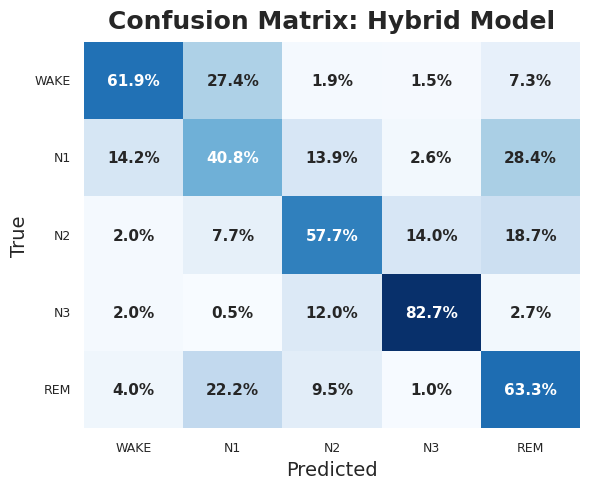

In [38]:
# Confusion matrix for the hybrid model.
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = ['WAKE', 'N1', 'N2', 'N3', 'REM']

cm = confusion_matrix(y_true_4, y_pred_4, normalize = 'true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='.1%',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 11, "weight": "bold"},
            cbar=False)  # <--- MODIFICA QUI: Rimuove la barra laterale

plt.title('Confusion Matrix: Hybrid Model', fontsize = 18, fontweight = 'bold', pad=10)
plt.ylabel('True', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()